## Flair upos etiketiranje

U ovoj svesci:
- Učitavamo UD_SERBIAN korpus pomoću Flair radnog okvira. To je skup rečenica na srpskom jeziku koje su ručno etiketiranje na nivou tokena
- Učitavano već istrenirana ugnježdavanja (embedding) reči koje nudi Flair radni okvir
- Pravimo model za upos etiketiranje koji se oslanja na učitana ugnježdavanja 
    - optimizujemo model na prostoru hiperparametra koristeći validacioni skup validacionih podataka
    - treniramo model još jednom sa najboljim parametrima
    - evaluiramo tako dobijeni model

### Učitavanje podataka i pretprocesiranje

In [1]:
import json
import flair.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from flair.data import Sentence
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn import metrics
from flair.datasets import ColumnCorpus

In [2]:
corpus = flair.datasets.UD_SERBIAN().downsample(0.4)

2022-09-01 14:52:37,048 Reading data from C:\Users\vladimir\.flair\datasets\ud_serbian
2022-09-01 14:52:37,049 Train: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-train.conllu
2022-09-01 14:52:37,050 Dev: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-dev.conllu
2022-09-01 14:52:37,050 Test: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-test.conllu


#### Analiza podataka

##### UPOS etikete:
- ADJ: pridev
- ADP: apozicija
- ADV: prilog
- AUX: pomoćni glagoli
- CCONJ: naporedni veznici
- DET: odrednice
- INTJ: uzvici
- NOUN: imenice
- NUM: brojevi
- PART: frazalni glagoli
- PRON: zamenica
- PROPN: vlastite imenice
- PUNCT: znakovi interpunkcije
- SCONJ: zavisni veznik
- SYM: simboli
- VERB: glagoli
- X: ostalo

In [3]:
tags = ["ADJ","ADP", 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

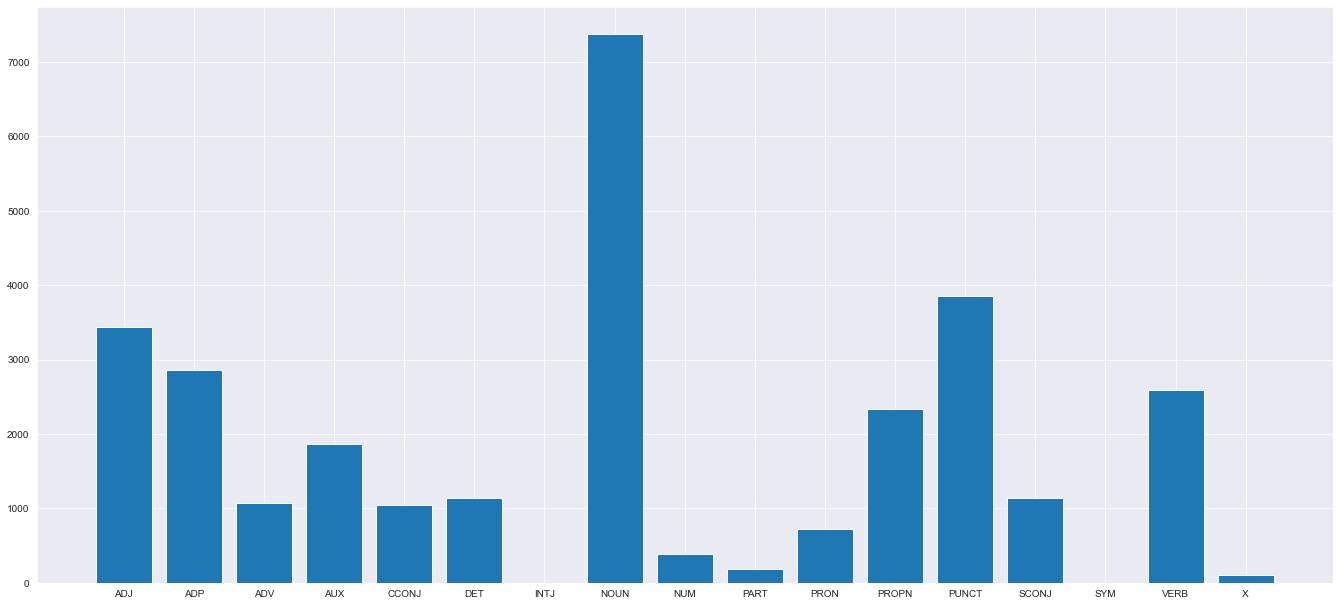

In [4]:
a = corpus.get_label_distribution()

freq = {}
for tag in tags:
    freq[tag] = a[tag]
    
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.bar(tags,freq.values())
plt.show()

In [5]:
# Ispisujemo broj recenica u svakom u podeli skupova
print("Training: ",len(corpus.train))
print("Test: ",len(corpus.test))
print("Dev: ",len(corpus.dev))

Training:  1331
Test:  208
Dev:  214


#### Pretprocesiranje podataka
Pošto podaci za treniranje UPOS tagger-a moraju biti u tačno određenom formatu, jedini korak neophodan u pretprocesiranju je da dodelimo svakoj reči UPOS tag ako ga ona već nema. Odnosno ako tag nije u pravilnom formatu, dodeljujemo joj tag "X". UPOS tag "X" označava da se radi o "other" tipu reči, pošto ne možemo da zaključimo ništa više o samoj reči bez njene dalje analize.

In [6]:
for sentence in corpus.get_all_sentences():
    for token in sentence:
        if token.get_label('upos').value not in tags:
            token.set_label('upos', 'X')

#### Prikaz učitane recenice i etiketiranih rečeničnih tokena iz validacionog skupa korpusa

In [7]:
sentence = corpus.dev[1]
print(sentence)
for token in sentence:
    print(token)

Sentence: "Tu je i etnička komponenta , s obzirom da pojedinci iz različitih zajednica mogu da kažu da je diskriminacija -- bilo sada ili ranije -- uticala na njihovu mogućnost ostvarivanja koristi od privatizacije ." → ["Tu"/tu/ADV/Rgp/advmod/Pos/Dem, "je"/biti/AUX/Var3s/root/Ind/Sing/3/Pres/Fin, "i"/i/CCONJ/Cc/discourse, "etnička"/etnički/ADJ/Agpfsny/amod/Nom/Def/Pos/Fem/Sing, "komponenta"/komponenta/NOUN/Ncfsn/nsubj/Nom/Fem/Sing, ","/,/PUNCT/Z/punct, "s"/sa/ADP/Si/mark/Ins, "obzirom"/obzir/NOUN/Ncmsi/fixed/Ins/Masc/Sing, "da"/da/SCONJ/Cs/fixed, "pojedinci"/pojedinac/NOUN/Ncmpn/nsubj/Nom/Masc/Plur, "iz"/iz/ADP/Sg/case/Gen, "različitih"/različit/ADJ/Agpfpgy/amod/Gen/Def/Pos/Fem/Plur, "zajednica"/zajednica/NOUN/Ncfpg/nmod/Gen/Fem/Plur, "mogu"/moći/VERB/Vmr3p/advcl/Ind/Plur/3/Pres/Fin, "da"/da/SCONJ/Cs/mark, "kažu"/kazati/VERB/Vmr3p/xcomp/Ind/Plur/3/Pres/Fin, "da"/da/SCONJ/Cs/mark, "je"/biti/AUX/Var3s/aux/Ind/Sing/3/Pres/Fin, "diskriminacija"/diskriminacija/NOUN/Ncfsn/nsubj/Nom/Fem/Sing

#### Pravljenje rečnika

In [8]:
# Pravljenje rečnika  sa UPOS etiketama iz korpusa
label_type = 'upos'
label_dict  = corpus.make_label_dictionary(label_type = label_type)
print(label_dict)

2022-09-01 14:52:42,469 Computing label dictionary. Progress:


1331it [00:00, 20166.09it/s]

2022-09-01 14:52:42,624 Dictionary created for label 'upos' with 17 values: NOUN (seen 7372 times), PUNCT (seen 3855 times), ADJ (seen 3436 times), ADP (seen 2855 times), VERB (seen 2588 times), PROPN (seen 2331 times), AUX (seen 1861 times), DET (seen 1145 times), SCONJ (seen 1139 times), ADV (seen 1070 times), CCONJ (seen 1045 times), PRON (seen 724 times), NUM (seen 392 times), PART (seen 185 times), X (seen 100 times), INTJ (seen 1 times)
Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ


### Nagomilana ugnjezdavanja
Više različitih ugnjezdavanja je moguće koristiti istovremeno pomoću `StackedEmbeddings` klase iz `Flair`-a. U našem primeru iskoristili smo:
1. `GloVe` ugnjezdavanja - bazira se na nalaženju korelacije izmedju parova reči na osnovu frekvencije korišćenja u tandemu
2. `Flair` ugnjezdavanja - embedding koji su razvili tvorci `Flair` biblioteke - koristimo i ugnjezdavanje i unapred i unazad kako bi se uhvatio ceo okolni kontekst reči

In [9]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

### Klasa za etiketiranje (`Tagger`)
Na osnovu kombinacije navedenih ugnjezdavanja generišemo `SequenceTagger` koji ćemo koristiti da na osnovu dobijenih vektorskih reprezentacija reči predvidimo UPOS etikete korespondirajuće reči.

In [10]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

2022-09-01 14:52:45,989 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ


### Treniranje modela i traženje optimalnih hiperparametara

In [11]:
trainer = ModelTrainer(tagger, corpus)

In [12]:
best_score = 0.0
best_params = {'learning_rate':0, 'mini_batch_size': 0, 'max_epochs' : 10}

param_learning_rates = np.linspace(0.001, 0.6, num=4)
param_mini_batch_sizes = np.arange(10,100,20)
max_epochs = np.arange(10,13,1)

model_history = []

In [13]:
for i,lr in enumerate(param_learning_rates):
    for j,mbs in enumerate(param_mini_batch_sizes):
        for k,me in enumerate(max_epochs):
                print('\n\n\n')
                print("#######################################################")
                print(f"############### MODEL NUMBER {i},{j},{k} #####################")
                print("#######################################################")
                trainer.train('resources/model_library/flair_upos_tagging',
                              learning_rate=lr,
                              mini_batch_size=int(mbs),
                              max_epochs=int(me),
                              write_weights = True)
                model = SequenceTagger.load('resources/model_library/flair_upos_tagging/final-model.pt')
                actual= np.array([])
                predicted = np.array([])

                # Provera preciznosti
                for actualSentence in corpus.dev:

                    for token in actualSentence:
                        actual = np.append(actual, token.get_label('upos').value)

                    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
                    model.predict(predictedSentence)
                    for token in predictedSentence:
                        predictedLabels = token.get_labels('upos')
                        for predictedLabel in predictedLabels:
                            predicted = np.append(predicted, predictedLabel.value)
                score = metrics.accuracy_score(actual,predicted)

                if score>best_score:
                    best_params['learning_rate'] = lr
                    best_params['param_mini_batch_sizes'] = mbs
                    best_params['max_epochs'] = me

                report = metrics.classification_report(actual,predicted)
                params = {'learning_rate': lr, 'param_mini_batch_sizes': mbs,
                          'max_epochs': me}

                # Takodje cuvamo i istoriju parapetara sa njihovim rezultatima metrika za svaki slucaj
                model_history.append({'params':params,'report':report})

IZLAZ ISPOD JE RUCNO SKRACEN RADI CITLJIVOSTI. OSTAVLJENI SU SAMO NEKI ISPISI



#######################################################
############### MODEL NUMBER 0,0,0 #####################
#######################################################
2022-09-01 14:52:46,174 ----------------------------------------------------------------------------------------------------
2022-09-01 14:52:46,175 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn):

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 14:53:16,950 epoch 1 - iter 13/134 - loss 3.56824505 - samples/sec: 4.23 - lr: 0.001000
2022-09-01 14:53:50,547 epoch 1 - iter 26/134 - loss 3.52225975 - samples/sec: 3.88 - lr: 0.001000
2022-09-01 14:54:21,590 epoch 1 - iter 39/134 - loss 3.50681684 - samples/sec: 4.20 - lr: 0.001000
2022-09-01 14:54:55,214 epoch 1 - iter 52/134 - loss 3.48097866 - samples/sec: 3.88 - lr: 0.001000
2022-09-01 14:55:35,433 epoch 1 - iter 65/134 - loss 3.45529235 - samples/sec: 3.24 - lr: 0.001000
2022-09-01 14:56:12,025 epoch 1 - iter 78/134 - loss 3.43442211 - samples/sec: 3.56 - lr: 0.001000
2022-09-01 14:56:44,266 epoch 1 - iter 91/134 - loss 3.41079068 - samples/sec: 4.04 - lr: 0.001000
2022-09-01 14:57:13,306 epoch 1 - iter 104/134 - loss 3.39138562 - samples/sec: 4.49 - lr: 0.001000
2022-09-01 14:57:47,039 epoch 1 - iter 117/134 - loss 3.36609904 - samples/sec: 3.86 - lr: 0.001000
2022-09-01 14:58:21,233 epoch 1 - iter 130/134 - loss 3.35645600 - samples/sec: 3.81 - lr: 0.001000
2022-09

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:42:05,326 epoch 1 - iter 1/15 - loss 0.17083740 - samples/sec: 38.61 - lr: 0.600000
2022-09-02 01:42:08,379 epoch 1 - iter 2/15 - loss 0.18043606 - samples/sec: 30.27 - lr: 0.600000
2022-09-02 01:42:11,080 epoch 1 - iter 3/15 - loss 0.18537177 - samples/sec: 34.36 - lr: 0.600000
2022-09-02 01:42:13,155 epoch 1 - iter 4/15 - loss 0.18933197 - samples/sec: 45.07 - lr: 0.600000
2022-09-02 01:42:15,635 epoch 1 - iter 5/15 - loss 0.18926180 - samples/sec: 37.44 - lr: 0.600000
2022-09-02 01:42:18,000 epoch 1 - iter 6/15 - loss 0.18056138 - samples/sec: 39.40 - lr: 0.600000
2022-09-02 01:42:20,326 epoch 1 - iter 7/15 - loss 0.17781038 - samples/sec: 40.11 - lr: 0.600000
2022-09-02 01:42:23,443 epoch 1 - iter 8/15 - loss 0.17500302 - samples/sec: 29.60 - lr: 0.600000
2022-09-02 01:42:26,045 epoch 1 - iter 9/15 - loss 0.17720102 - samples/sec: 35.60 - lr: 0.600000
2022-09-02 01:42:28,514 epoch 1 - iter 10/15 - loss 0.17717434 - samples/sec: 37.53 - lr: 0.600000
2022-09-02 01:42:30

In [15]:
def serialize_int32(obj):
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError ("Type %s is not serializable" % type(obj))

In [16]:
# Cuvanje rezultata
with open(f"resources/model_library/flair_upos_tagging/best_params.json", "w") as f:
     f.write(json.dumps(best_params, default=serialize_int32, indent=4))

In [17]:
with open(f"resources/model_library/flair_upos_tagging/model_hist.json", "w") as f:
    f.write(json.dumps(model_history, default=serialize_int32, indent=4))

Opet treniramo model sa najvećom prezinošću dobijen isprobavanjem potprostora hipeparametara.

In [18]:
trainer.train('resources/model_library/flair_upos_tagging',
                              learning_rate=best_params['learning_rate'],
                              mini_batch_size=int(best_params['param_mini_batch_sizes']),
                              max_epochs=int(best_params['max_epochs']),
                              write_weights = True)



IZLAZ ISPOD JE RUCNO SKRACEN RADI CITLJIVOSTI. OSTAVLJENI SU SAMO NEKI ISPISI

2022-09-02 01:52:46,254 ----------------------------------------------------------------------------------------------------
2022-09-02 01:52:46,255 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): Loc

{'test_score': 0.9505269950526996,
 'dev_score_history': [0.9319466882067852,
  0.9309369951534734,
  0.9343699515347335,
  0.9339660743134087,
  0.9315428109854604,
  0.9258885298869144,
  0.9343699515347335,
  0.9345718901453958,
  0.9333602584814217,
  0.934168012924071,
  0.9258885298869144,
  0.9373990306946688],
 'train_loss_history': [0.19337838777866373,
  0.20039890496777302,
  0.2061076053191136,
  0.19311480447855411,
  0.1986591383849962,
  0.20779273449699326,
  0.19468618143459915,
  0.19398238417389282,
  0.1949312710762816,
  0.19862812095086216,
  0.18821612636632445,
  0.19487105312884148],
 'dev_loss_history': [0.24547412991523743,
  0.2810230255126953,
  0.25854727625846863,
  0.25668683648109436,
  0.27172890305519104,
  0.26797589659690857,
  0.2568742036819458,
  0.24655205011367798,
  0.26324018836021423,
  0.26793545484542847,
  0.2834279537200928,
  0.25658586621284485]}

In [19]:
# Učitavamo istrenirani model
model = SequenceTagger.load('resources/model_library/flair_upos_tagging/final-model.pt')

2022-09-02 02:01:54,156 loading file resources/model_library/flair_upos_tagging/final-model.pt
2022-09-02 02:01:54,667 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


## Evaluacija modela

In [22]:
# Ispisivanje primera tokena iz jedne recenice, njihovih tagova, kao i predvidjenih tagova uz pomoc modela
sentence = corpus.test[78]
model.predict(sentence)
print("\n\n")

# Predvidi etikete i štampaj
for i,token in enumerate(sentence):
    predictedLabels = token.get_labels('upos')
    actualLabels = sentence[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




Razgovori - predicted: NOUN , actual: NOUN
su - predicted: AUX , actual: AUX
bili - predicted: AUX , actual: AUX
usmereni - predicted: ADJ , actual: ADJ
na - predicted: ADP , actual: ADP
bilateralne - predicted: ADJ , actual: ADJ
veze - predicted: NOUN , actual: NOUN
i - predicted: CCONJ , actual: CCONJ
situaciju - predicted: NOUN , actual: NOUN
na - predicted: ADP , actual: ADP
Bliskom - predicted: ADJ , actual: ADJ
istoku - predicted: NOUN , actual: NOUN
. - predicted: PUNCT , actual: PUNCT


### Generisanje matrice konfuzije na test skupu korpusa

In [28]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus.test:

    for token in actualSentence:
        actual = np.append(actual, token.get_label('upos').value)

    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
    model.predict(predictedSentence)
    for token in predictedSentence:
        predictedLabels = token.get_labels('upos')
        for predictedLabel in predictedLabels:
            predicted = np.append(predicted, predictedLabel.value)

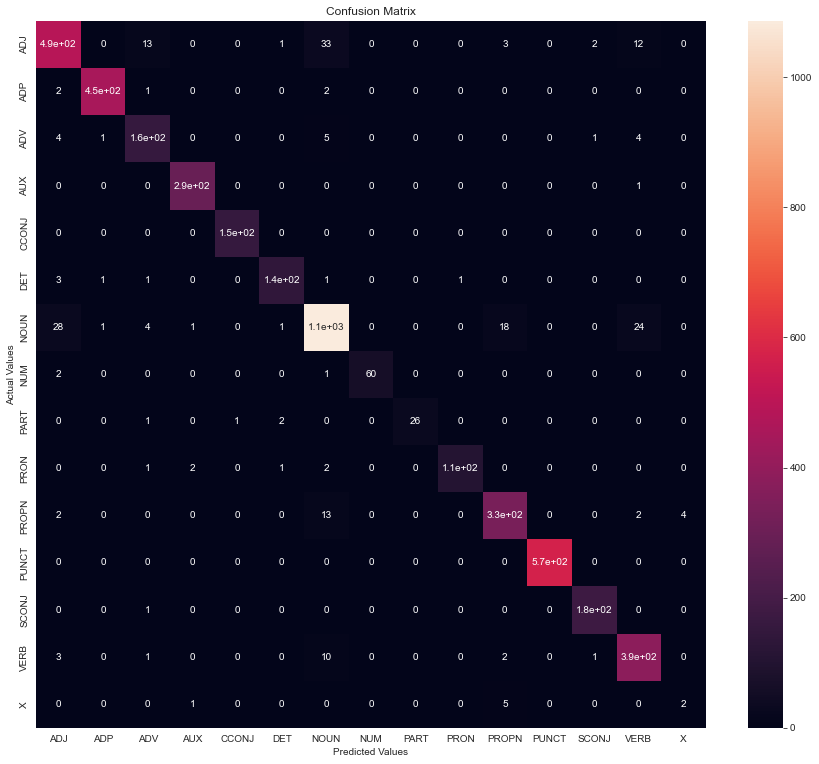

In [29]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Izveštaj o klasifikaciji

In [30]:
print(metrics.classification_report(actual,predicted))

              precision    recall  f1-score   support

         ADJ       0.92      0.88      0.90       553
         ADP       0.99      0.99      0.99       456
         ADV       0.87      0.91      0.89       171
         AUX       0.99      1.00      0.99       291
       CCONJ       0.99      1.00      1.00       154
         DET       0.96      0.95      0.96       143
        NOUN       0.94      0.93      0.94      1163
         NUM       1.00      0.95      0.98        63
        PART       1.00      0.87      0.93        30
        PRON       0.99      0.95      0.97       112
       PROPN       0.92      0.94      0.93       354
       PUNCT       1.00      1.00      1.00       572
       SCONJ       0.98      0.99      0.99       176
        VERB       0.90      0.96      0.93       403
           X       0.33      0.25      0.29         8

    accuracy                           0.95      4649
   macro avg       0.92      0.91      0.91      4649
weighted avg       0.95   

In [31]:
text_file = open(f"resources/model_library/flair_upos_tagging/report.txt", "w")
text_file.write(metrics.classification_report(actual,predicted))
text_file.close()

### Primer predikcije UPOS etiketa na nivou reči datih u rečenici

In [32]:
sentence = Sentence('Srbija je tokom bombardovanja 1990 devedesetih izgubila mnoge kulturne znamenitosti.')

# predviđanje etiketa
model.predict(sentence)

print(sentence.to_tagged_string())

Sentence: "Srbija je tokom bombardovanja 1990 devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/PROPN, "je"/AUX, "tokom"/ADP, "bombardovanja"/NOUN, "1990"/NUM, "devedesetih"/ADJ, "izgubila"/NOUN, "mnoge"/ADJ, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]
